## Análisis Temporal de la Lista de Espera

### Examinar cómo ha evolucionado la lista de espera a lo largo del tiempo, identificando posibles tendencias o patrones estacionales en la demanda de órganos

### Llibrerías

In [7]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

### Carga de datos, procesamiento y exploración

In [8]:
#Cargar del dataset
file_path = './Pacientes_en_espera.csv'
data = pd.read_csv(file_path)

#Función para ajustar los formatos de las fechas
def convertir_fecha(columna):
    return pd.to_datetime(data[columna], format='%d/%m/%Y %H:%M:%S')

#Ajusta los valores de las fechas
data['FECHA_NACIMIENTO'] = convertir_fecha('FECHA_NACIMIENTO')
data['FECHA_REGISTRO_COMITE'] = convertir_fecha('FECHA_REGISTRO_COMITE')

#Calcula la edad
data['EDAD_REGISTRO'] = data['FECHA_REGISTRO_COMITE'].dt.year - data['FECHA_NACIMIENTO'].dt.year

#Calcula el tiempo de espera
fecha_corte = pd.Timestamp(datetime.now())
data['TIEMPO_ESPERA'] = (fecha_corte - data['FECHA_REGISTRO_COMITE']).dt.days

#Muestra los primeros registros
print(data.head())

        SEXO  CODIGO_SEXO GRUPO_SANGUINEO        RH FECHA_NACIMIENTO  \
0   FEMENINO            2               O  POSITIVO       1946-09-07   
1  MASCULINO            1               O  POSITIVO       1984-11-15   
2   FEMENINO            2               O  NEGATIVO       2002-01-01   
3   FEMENINO            2               O  POSITIVO       2002-02-01   
4   FEMENINO            2               O  NEGATIVO       2002-05-01   

  FECHA_REGISTRO_COMITE ORGANO ORIGEN_INJERTO  \
0            2002-02-12  RIÑÓN        CADAVER   
1            2002-02-12  RIÑÓN        CADAVER   
2            2002-02-25  RIÑÓN        CADAVER   
3            2002-03-27  RIÑÓN        CADAVER   
4            2002-05-05  RIÑÓN        CADAVER   

                                     ESTABLECIMIENTO INSTITUCION  \
0  UNIDAD MEDICA DE ALTA ESPECIALIDAD HOSPITAL DE...        IMSS   
1  UNIDAD MEDICA DE ALTA ESPECIALIDAD HOSPITAL DE...        IMSS   
2  UNIDAD MEDICA DE ALTA ESPECIALIDAD HOSPITAL DE...        IMSS   


In [9]:
data.describe

<bound method NDFrame.describe of             SEXO  CODIGO_SEXO GRUPO_SANGUINEO         RH FECHA_NACIMIENTO  \
0       FEMENINO            2               O   POSITIVO       1946-09-07   
1      MASCULINO            1               O   POSITIVO       1984-11-15   
2       FEMENINO            2               O   NEGATIVO       2002-01-01   
3       FEMENINO            2               O   POSITIVO       2002-02-01   
4       FEMENINO            2               O   NEGATIVO       2002-05-01   
...          ...          ...             ...        ...              ...   
23205   FEMENINO            2       NO APLICA  NO APLICA       1987-02-26   
23206  MASCULINO            1               O   POSITIVO       2010-09-11   
23207   FEMENINO            2               O   POSITIVO       1963-09-30   
23208  MASCULINO            1       NO APLICA  NO APLICA       1993-12-01   
23209  MASCULINO            1       NO APLICA  NO APLICA       1962-01-18   

      FECHA_REGISTRO_COMITE  ORGANO ORIGE

### Visualización de datos

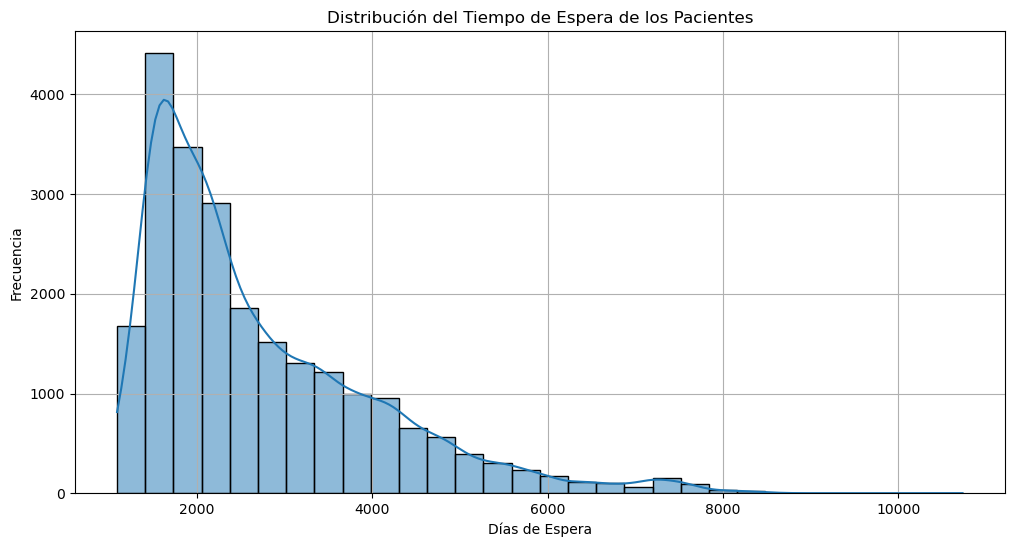

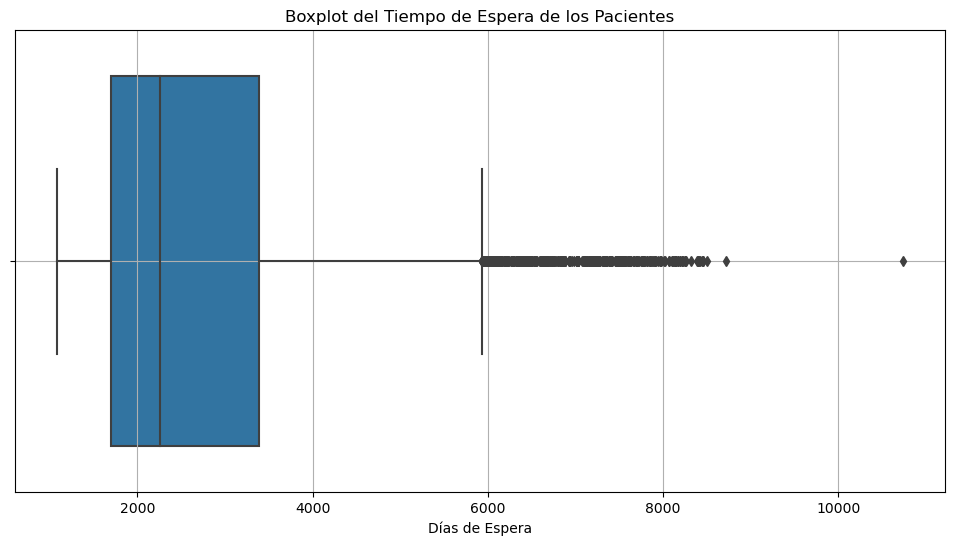


Estadísticas descriptivas

       EDAD_REGISTRO  TIEMPO_ESPERA
count   23210.000000   23210.000000
mean       41.026109    2709.291469
std        17.217268    1330.207245
min         0.000000    1085.000000
25%        27.000000    1702.000000
50%        39.000000    2262.500000
75%        53.000000    3393.000000
max       112.000000   10733.000000


In [10]:
#Análisis de la distribución del tiempo de espera
plt.figure(figsize=(12, 6))
sns.histplot(data['TIEMPO_ESPERA'], kde=True, bins=30)
plt.title('Distribución del Tiempo de Espera de los Pacientes')
plt.xlabel('Días de Espera')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

#Análisis de outliers en el tiempo de espera
plt.figure(figsize=(12, 6))
sns.boxplot(x=data['TIEMPO_ESPERA'])
plt.title('Boxplot del Tiempo de Espera de los Pacientes')
plt.xlabel('Días de Espera')
plt.grid(True)
plt.show()

#Estadísticas descriptivas básicas
estadisticas_descriptivas = data[['EDAD_REGISTRO', 'TIEMPO_ESPERA']].describe()
print('\nEstadísticas descriptivas\n')
print(estadisticas_descriptivas)

### Análisis de datos

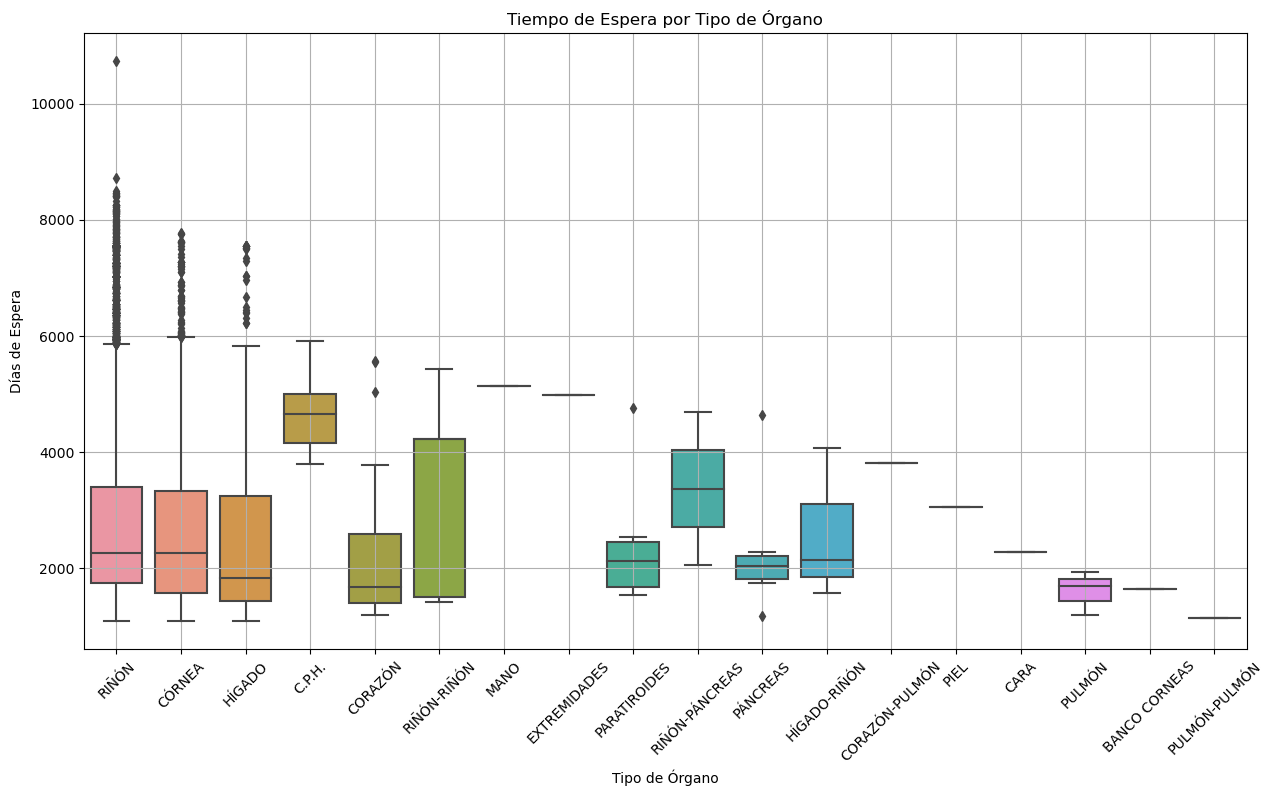

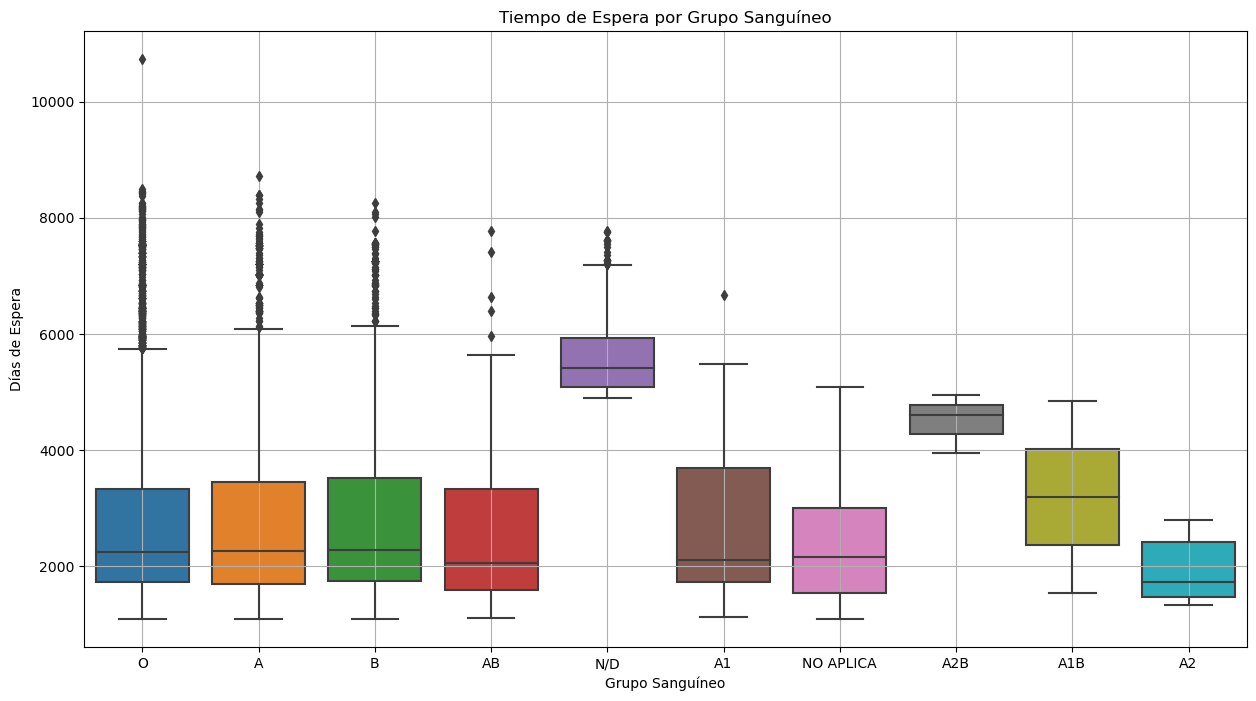

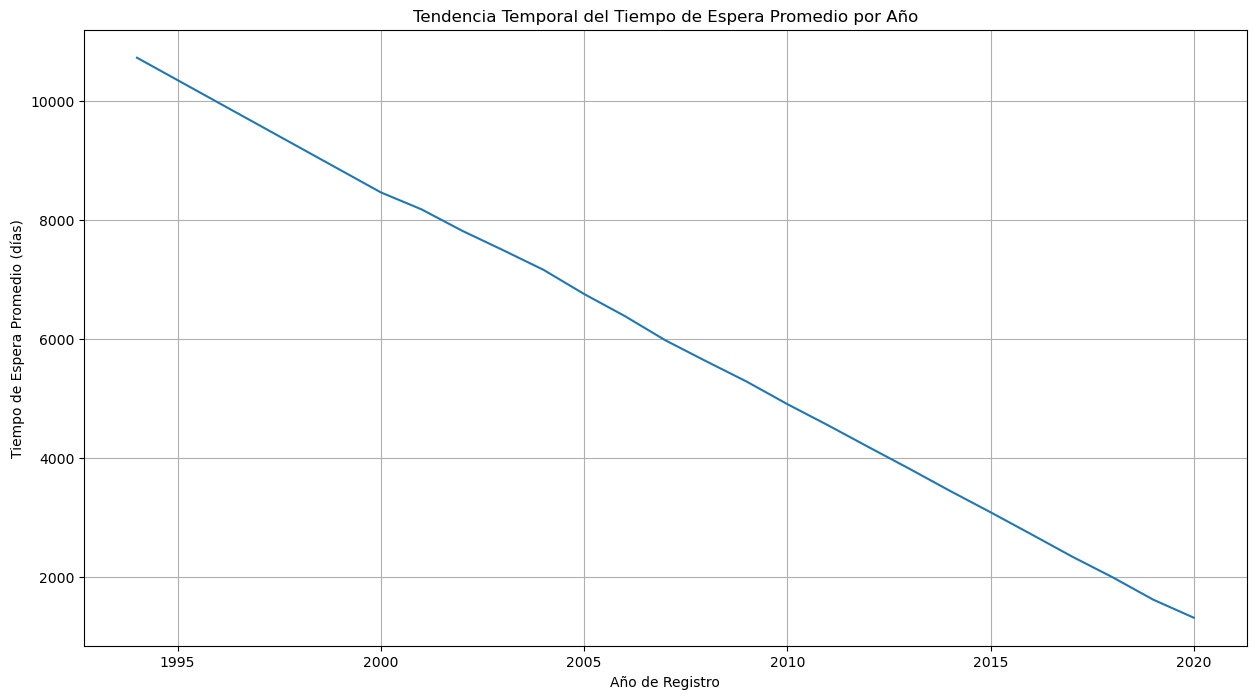

In [11]:
#Comparación de tiempos de espera por tipo de órgano
plt.figure(figsize=(15, 8))
sns.boxplot(x='ORGANO', y='TIEMPO_ESPERA', data=data)
plt.title('Tiempo de Espera por Tipo de Órgano')
plt.xlabel('Tipo de Órgano')
plt.ylabel('Días de Espera')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#Comparación de tiempos de espera por grupo sanguíneo
plt.figure(figsize=(15, 8))
sns.boxplot(x='GRUPO_SANGUINEO', y='TIEMPO_ESPERA', data=data)
plt.title('Tiempo de Espera por Grupo Sanguíneo')
plt.xlabel('Grupo Sanguíneo')
plt.ylabel('Días de Espera')
plt.grid(True)
plt.show()

#Análisis de tendencias temporales en el tiempo de espera
data['AÑO_REGISTRO'] = data['FECHA_REGISTRO_COMITE'].dt.year
tendencia_temporal = data.groupby('AÑO_REGISTRO')['TIEMPO_ESPERA'].mean().reset_index()

plt.figure(figsize=(15, 8))
sns.lineplot(x='AÑO_REGISTRO', y='TIEMPO_ESPERA', data=tendencia_temporal)
plt.title('Tendencia Temporal del Tiempo de Espera Promedio por Año')
plt.xlabel('Año de Registro')
plt.ylabel('Tiempo de Espera Promedio (días)')
plt.grid(True)
plt.show()

### Modelo predictivo

In [19]:
#Preparación de datos 
data_encoded = pd.get_dummies(data, columns=['SEXO', 'GRUPO_SANGUINEO', 'RH', 'ORGANO', 'INSTITUCION'], drop_first=True)

#Se remueven columnas
features = data_encoded.drop(['FECHA_NACIMIENTO', 'FECHA_REGISTRO_COMITE', 'ORIGEN_INJERTO', 'ESTABLECIMIENTO',
                              'ENTIDAD_FEDERATIVA_ESTABLECIMIENTO', 'ESTADO_DE_ORIGEN_PACIENTE',
                              'CODIGO_ENTIDAD_FEDERATIVA_ESTABLECIMIENTO', 'ESTADO_DE_RESIDENCIA_PACIENTE',
                              'CODIGO_ENTIDAD_FEDERATIVA_RESIDENCIA_PACIENTE', 'AÑO_REGISTRO', 'TIEMPO_ESPERA'], axis=1)
target = data_encoded['TIEMPO_ESPERA']

#Conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# Modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

#Predicción y evaluación del modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

#Coeficientes del modelo
coeficientes = pd.Series(model.coef_, index=features.columns)

#Resultados
print("Error cuadrático medio (MSE):", mse)
print("Coeficientes del modelo:\n", coeficientes.sort_values(ascending=False))


Error cuadrático medio (MSE): 1414724.608535585
Coeficientes del modelo:
 GRUPO_SANGUINEO_A2B                          1.960552e+03
ORGANO_CORAZÓN-PULMÓN                        1.907740e+03
GRUPO_SANGUINEO_N/D                          1.895155e+03
ORGANO_C.P.H.                                1.478314e+03
ORGANO_HÍGADO-RIÑÓN                          1.229928e+03
ORGANO_PIEL                                  1.224441e+03
ORGANO_RIÑÓN-RIÑÓN                           8.976017e+02
GRUPO_SANGUINEO_A1B                          6.432973e+02
ORGANO_RIÑÓN                                 4.292904e+02
ORGANO_CÓRNEA                                3.798115e+02
ORGANO_PARATIROIDES                          3.204477e+02
INSTITUCION_ISSSTE                           2.348976e+02
ORGANO_HÍGADO                                2.166027e+02
INSTITUCION_SEDENA                           1.521006e+02
GRUPO_SANGUINEO_A1                           1.513709e+02
ORGANO_CORAZÓN                               6.306476e+0

- La predicción no fue buena, se requiere analizar con más detalle cada una de las variables que se consideran influyen en la predicción. Posiblemente se eliminaron algunas que son relevantes.
- Se requiere igualmente dar tratamiento a los valores outliers
- Revisar el escalamiento de los valores que se están utilizando